In [1]:
import warnings
warnings.filterwarnings('ignore')
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot

In [2]:
df = pd.read_excel('Data/all_data.xlsx')

In [3]:
df

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
0,2023-03-01,23150.929688,23880.632813,23088.626953,23646.550781,24662841200,positif,43,23646.550781
1,2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,20386398516,negatif,45,23475.466797
2,2023-03-03,23476.632813,23479.347656,22213.238281,22362.679688,26062404610,negatif,52,22362.679688
3,2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,11166012913,negatif,40,22353.349609
4,2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,13317001733,negatif,38,22435.513672
...,...,...,...,...,...,...,...,...,...
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063


# PREPROCESSING

In [4]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
df['Sentimen'] = df['Sentimen'].map(sentimen_mapping)

In [5]:
X = df.drop(columns=["Date", "Adj_Close", "Close"])  
y = df["Close"] 

In [6]:
# Membuat skenario dan scaling
scenarios = {
    "scen1": ["Open", "High", "Low"],  # Harga saja
    "scen2": ["Open", "High", "Low", "Sentimen"],  # Harga + Sentimen
    "scen3": ["Open", "High", "Low", "Index"],  # Harga + Index
    "scen4": ["Open", "High", "Low", "Volume"],  # Harga + Volume
    "scen5": ["Open", "High", "Low", "Sentimen", "Index"],  # Harga + Sentimen + Index
    "scen6": ["Open", "High", "Low", "Sentimen", "Volume"],  # Harga + Sentimen + Volume
    "scen7": ["Open", "High", "Low", "Volume", "Index"],  # Harga + Volume + Index
    "scen8": ["Open", "High", "Low", "Sentimen", "Index", "Volume"]  # Harga + Sentimen + Index + Volume
}

scaled_scenarios = {}

for scen_name, columns in scenarios.items():
    X, y, scaler = scale_data(df, subset_columns=columns, target_column="Close")
    scaled_scenarios[scen_name] = (X, y)

In [7]:
# Mendefinisikan X dan y untuk setiap skenario
for i, scen in enumerate(scenarios, start=1):
    X_name = f"X_scen{i}"
    y_name = f"y_scen{i}"
    
    globals()[X_name], globals()[y_name] = scaled_scenarios[scen]
    
    print(f"{X_name}: {globals()[X_name].shape}")
    print(f"{y_name}: {globals()[y_name].shape}")

X_scen1: (365, 1, 3)
y_scen1: (365,)
X_scen2: (365, 1, 4)
y_scen2: (365,)
X_scen3: (365, 1, 4)
y_scen3: (365,)
X_scen4: (365, 1, 4)
y_scen4: (365,)
X_scen5: (365, 1, 5)
y_scen5: (365,)
X_scen6: (365, 1, 5)
y_scen6: (365,)
X_scen7: (365, 1, 5)
y_scen7: (365,)
X_scen8: (365, 1, 6)
y_scen8: (365,)


In [8]:
for i, scen in enumerate(scenarios, start=1):
    X_data, y_data = scaled_scenarios[scen]
    
    # Membagi data menjadi train dan test set
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
    
    globals()[f"X_train_scen{i}"] = X_train
    globals()[f"X_test_scen{i}"] = X_test
    globals()[f"y_train_scen{i}"] = y_train
    globals()[f"y_test_scen{i}"] = y_test
    
    print(f"Train/Test Split for scen{i}:")
    print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

    print("="*50)

Train/Test Split for scen1:
X_train: (292, 1, 3), X_test: (73, 1, 3)
y_train: (292,), y_test: (73,)
Train/Test Split for scen2:
X_train: (292, 1, 4), X_test: (73, 1, 4)
y_train: (292,), y_test: (73,)
Train/Test Split for scen3:
X_train: (292, 1, 4), X_test: (73, 1, 4)
y_train: (292,), y_test: (73,)
Train/Test Split for scen4:
X_train: (292, 1, 4), X_test: (73, 1, 4)
y_train: (292,), y_test: (73,)
Train/Test Split for scen5:
X_train: (292, 1, 5), X_test: (73, 1, 5)
y_train: (292,), y_test: (73,)
Train/Test Split for scen6:
X_train: (292, 1, 5), X_test: (73, 1, 5)
y_train: (292,), y_test: (73,)
Train/Test Split for scen7:
X_train: (292, 1, 5), X_test: (73, 1, 5)
y_train: (292,), y_test: (73,)
Train/Test Split for scen8:
X_train: (292, 1, 6), X_test: (73, 1, 6)
y_train: (292,), y_test: (73,)


# MODELING

In [9]:
def declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test):
    model = Sequential()    
    try:
        if n_lstm == 1:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif n_lstm == 2:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
        else:
            print("Invalid LSTM configuration")

        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        history = model.fit(X_train, y_train, batch_size=32, epochs=epoch, validation_data=(X_test, y_test))

        return history 
    except Exception as e:
        print(f"Error during model training: {e}")
        return None 

def tune_model_parameters(scenarios, lstm_configs):
    results = {} 

    for i, scen in enumerate(scenarios, start=1):
        X_train_data = globals()[f"X_train_scen{i}"]
        X_test_data = globals()[f"X_test_scen{i}"]
        y_train_data = globals()[f"y_train_scen{i}"]
        y_test_data = globals()[f"y_test_scen{i}"]
        
        print(f"Training model for scenario {i}")

        for n_lstm in lstm_configs['n_lstm']:
            for neuron in lstm_configs['neurons']:
                for epoch in lstm_configs['epochs']:
                    print(f'Running trial for scen{i} with n_lstm={n_lstm}, neuron={neuron}, epoch={epoch}')
                    key = f"scen{i}_n_lstm={n_lstm}_neurons={neuron}_epochs={epoch}"
                    history = declare_model(n_lstm, neuron, epoch, X_train_data, y_train_data, X_test_data, y_test_data)
                    
                    if history is not None:
                        mse_train = history.history['loss'][-1]  
                        mse_test = history.history['val_loss'][-1] 
                        results[key] = {'history': history.history, 'mse_train': mse_train, 'mse_test': mse_test}
                    else:
                        print(f"Skipping combination for scen{i} with n_lstm={n_lstm}, neuron={neuron}, epoch={epoch} due to error")

    return results

lstm_configs = {
    'n_lstm': [1, 2], 
    'neurons': [50, 100, 150, 200], 
    'epochs': [10, 20, 30]
}

In [10]:
results = tune_model_parameters(scenarios, lstm_configs)

Training model for scenario 1
Running trial for scen1 with n_lstm=1, neuron=50, epoch=10
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 292 samples, validate on 73 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
292/292 [==============================] - 1s 2ms/sample - loss: 0.0347 - val_loss: 0.0835
Epoch 2/10
292/292 [==============================] - 0s 92us/sample - loss: 0.0158 - val_loss: 0.0407
Epoch 3/10
292/292 [==============================] - 0s 79us/sample - loss: 0.0149 - val_loss: 0.0893
Epoch 4/10
292/292 [==============================] - 0s 92us/sample - loss: 0.0137 - val_loss: 0.1094
Epoch 5/10
292/292 [==============================] - 0s 106us/sample - loss: 0.0132 - val_loss: 0.0943
Epoch 6/10
292/292 [==============================] - 0s 88us/sample - loss: 0.0128 - val_loss: 0.0969
Epoch 7/10
292/292 [================

In [11]:
hasil = []

for i, scen in enumerate(scenarios, start=1):
    for key, value in results.items():
        if f"scen{i}" in key:
            mse_train = value['mse_train']
            mse_test = value['mse_test']

            experiment_key = f"scen={i}_n_lstm={key.split('n_lstm=')[1].split('_')[0]}_neurons={key.split('neurons=')[1].split('_')[0]}_epochs={key.split('epochs=')[1].split('_')[0]}"
            hasil.append({
                'experiment': experiment_key,
                'mse_train': mse_train,
                'mse_test': mse_test
            })

hp_lstm = pd.DataFrame(hasil)

for result in hasil:
    print(f"Experiment: {result['experiment']}, MSE Train: {result['mse_train']}, MSE Test: {result['mse_test']}")


Experiment: scen=1_n_lstm=1_neurons=50_epochs=10, MSE Train: 0.012465525035784669, MSE Test: 0.12091153411016073
Experiment: scen=1_n_lstm=1_neurons=50_epochs=20, MSE Train: 0.012270650290565132, MSE Test: 0.1504329404194061
Experiment: scen=1_n_lstm=1_neurons=50_epochs=30, MSE Train: 0.012318251884146912, MSE Test: 0.14025446252055365
Experiment: scen=1_n_lstm=1_neurons=100_epochs=10, MSE Train: 0.012790211323291471, MSE Test: 0.09870017146411007
Experiment: scen=1_n_lstm=1_neurons=100_epochs=20, MSE Train: 0.012258044935201537, MSE Test: 0.1555769322057293
Experiment: scen=1_n_lstm=1_neurons=100_epochs=30, MSE Train: 0.012310662124248552, MSE Test: 0.1438578871423251
Experiment: scen=1_n_lstm=1_neurons=150_epochs=10, MSE Train: 0.01256037356127819, MSE Test: 0.11523301144168802
Experiment: scen=1_n_lstm=1_neurons=150_epochs=20, MSE Train: 0.012342212747221123, MSE Test: 0.14200384863843657
Experiment: scen=1_n_lstm=1_neurons=150_epochs=30, MSE Train: 0.012275744117924, MSE Test: 0.13

In [12]:
hp_lstm

,experiment,mse_train,mse_test
0,scen=1_n_lstm=1_neurons=50_epochs=10,0.012466,0.120912
1,scen=1_n_lstm=1_neurons=50_epochs=20,0.012271,0.150433
2,scen=1_n_lstm=1_neurons=50_epochs=30,0.012318,0.140254
3,scen=1_n_lstm=1_neurons=100_epochs=10,0.012790,0.098700
4,scen=1_n_lstm=1_neurons=100_epochs=20,0.012258,0.155577
...,...,...,...
187,scen=8_n_lstm=2_neurons=150_epochs=20,0.000313,0.001041
188,scen=8_n_lstm=2_neurons=150_epochs=30,0.000336,0.001150
189,scen=8_n_lstm=2_neurons=200_epochs=10,0.000322,0.001171
190,scen=8_n_lstm=2_neurons=200_epochs=20,0.000347,0.001375


In [13]:
hp_lstm.to_excel("kombinasi-parameter-LSTM.xlsx")

In [14]:
hp_lstm['scenario'] = hp_lstm['experiment'].apply(lambda x: x.split('_')[0])

min_mse_per_scenario = hp_lstm.groupby('scenario')['mse_train'].idxmin()

for scenario, index in min_mse_per_scenario.items():
    min_mse_row = hp_lstm.loc[index]
    print(min_mse_row)
    print("="*50)

experiment    scen=1_n_lstm=2_neurons=100_epochs=30
mse_train                                  0.000334
mse_test                                   0.001169
scenario                                     scen=1
Name: 17, dtype: object
experiment    scen=2_n_lstm=2_neurons=100_epochs=30
mse_train                                  0.000311
mse_test                                   0.001027
scenario                                     scen=2
Name: 41, dtype: object
experiment    scen=3_n_lstm=2_neurons=150_epochs=30
mse_train                                  0.000322
mse_test                                   0.001344
scenario                                     scen=3
Name: 68, dtype: object
experiment    scen=4_n_lstm=2_neurons=100_epochs=20
mse_train                                  0.000325
mse_test                                   0.001154
scenario                                     scen=4
Name: 88, dtype: object
experiment    scen=5_n_lstm=2_neurons=150_epochs=20
mse_train           

In [15]:
hp_lstm['scenario'] = hp_lstm['experiment'].apply(lambda x: x.split('_')[0])

min_mse_per_scenario = hp_lstm.groupby('scenario')['mse_test'].idxmin()

for scenario, index in min_mse_per_scenario.items():
    min_mse_row = hp_lstm.loc[index]
    print(f"Scenario: {scenario}")
    print(min_mse_row)
    print("="*50)

Scenario: scen=1
experiment    scen=1_n_lstm=2_neurons=150_epochs=10
mse_train                                   0.00035
mse_test                                   0.001124
scenario                                     scen=1
Name: 18, dtype: object
Scenario: scen=2
experiment    scen=2_n_lstm=2_neurons=150_epochs=20
mse_train                                  0.000406
mse_test                                   0.001004
scenario                                     scen=2
Name: 43, dtype: object
Scenario: scen=3
experiment    scen=3_n_lstm=2_neurons=200_epochs=10
mse_train                                  0.000352
mse_test                                   0.001133
scenario                                     scen=3
Name: 69, dtype: object
Scenario: scen=4
experiment    scen=4_n_lstm=2_neurons=100_epochs=20
mse_train                                  0.000325
mse_test                                   0.001154
scenario                                     scen=4
Name: 88, dtype: object
Scen

In [16]:
exp = hp_lstm["experiment"]

scen = exp.str.extract(r"scen=(\d+)").astype(int)
n_lstm = exp.str.extract(r"n_lstm=(\d+)").astype(int)
neurons = exp.str.extract(r"neurons=(\d+)").astype(int)
epochs = exp.str.extract(r"epochs=(\d+)").astype(int)
mse_train = hp_lstm["mse_train"]
mse_test = hp_lstm["mse_test"]

hyperparam = pd.DataFrame({
    'scen': scen.squeeze(),
    'n_lstm': n_lstm.squeeze(),
    'neurons': neurons.squeeze(),
    'epochs': epochs.squeeze(),
    'mse_train': mse_train,
    'mse_test': mse_test
})

In [17]:
hyperparam

,scen,n_lstm,neurons,epochs,mse_train,mse_test
0,1,1,50,10,0.012466,0.120912
1,1,1,50,20,0.012271,0.150433
2,1,1,50,30,0.012318,0.140254
3,1,1,100,10,0.012790,0.098700
4,1,1,100,20,0.012258,0.155577
...,...,...,...,...,...,...
187,8,2,150,20,0.000313,0.001041
188,8,2,150,30,0.000336,0.001150
189,8,2,200,10,0.000322,0.001171
190,8,2,200,20,0.000347,0.001375


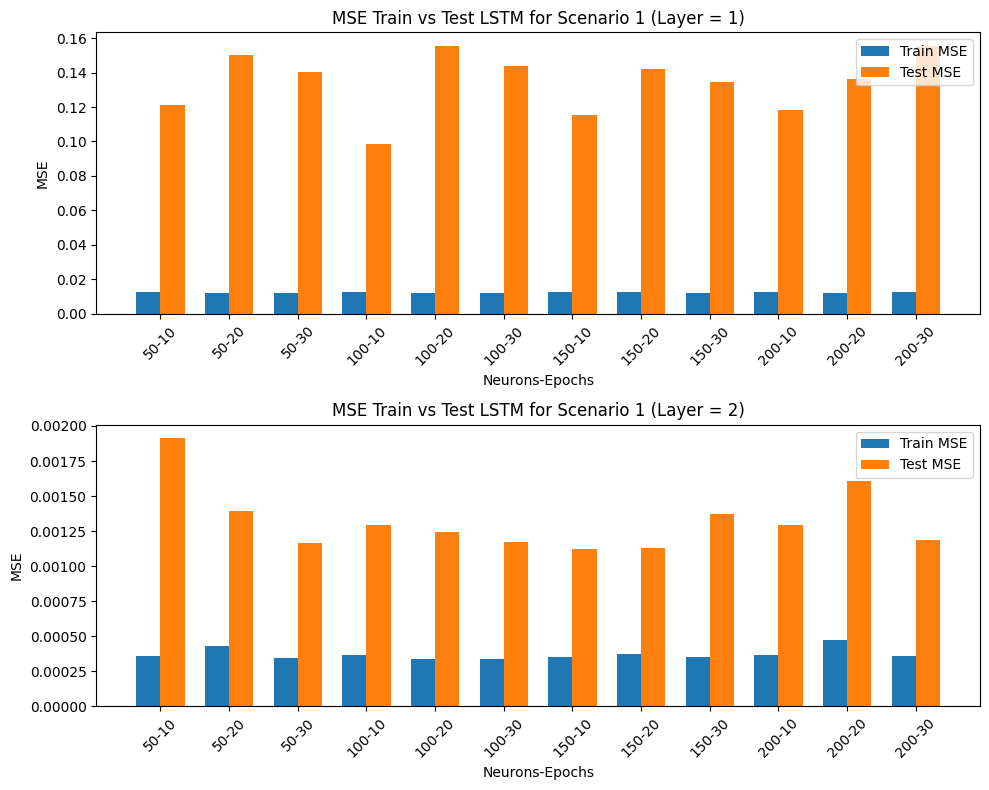

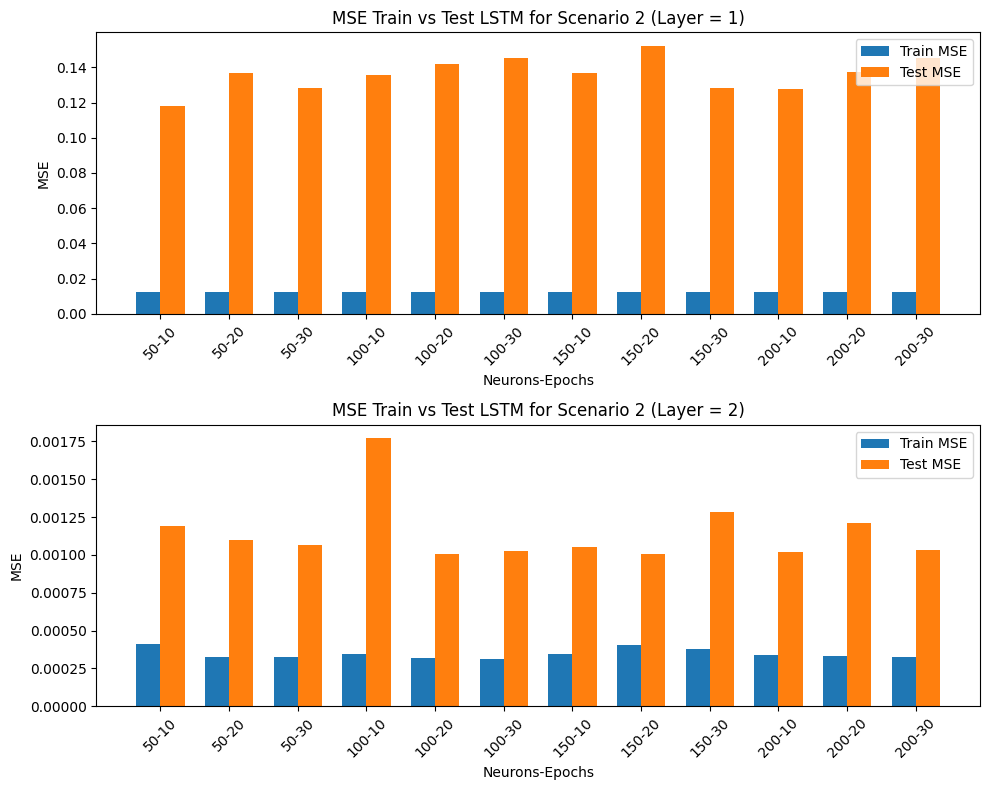

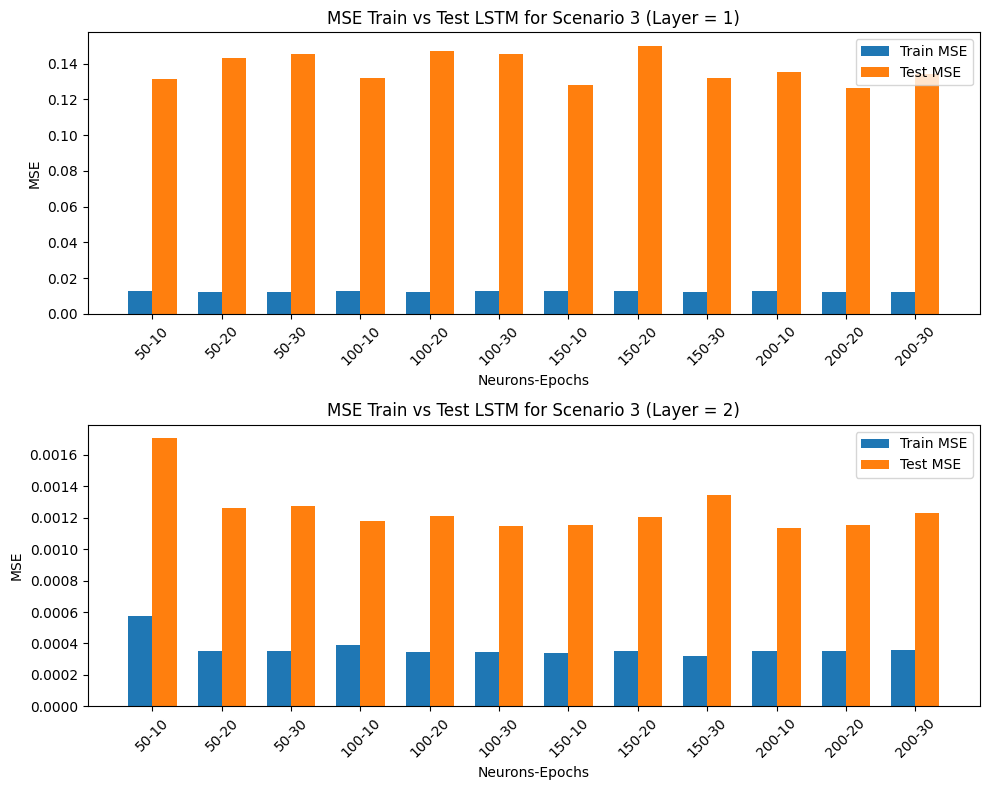

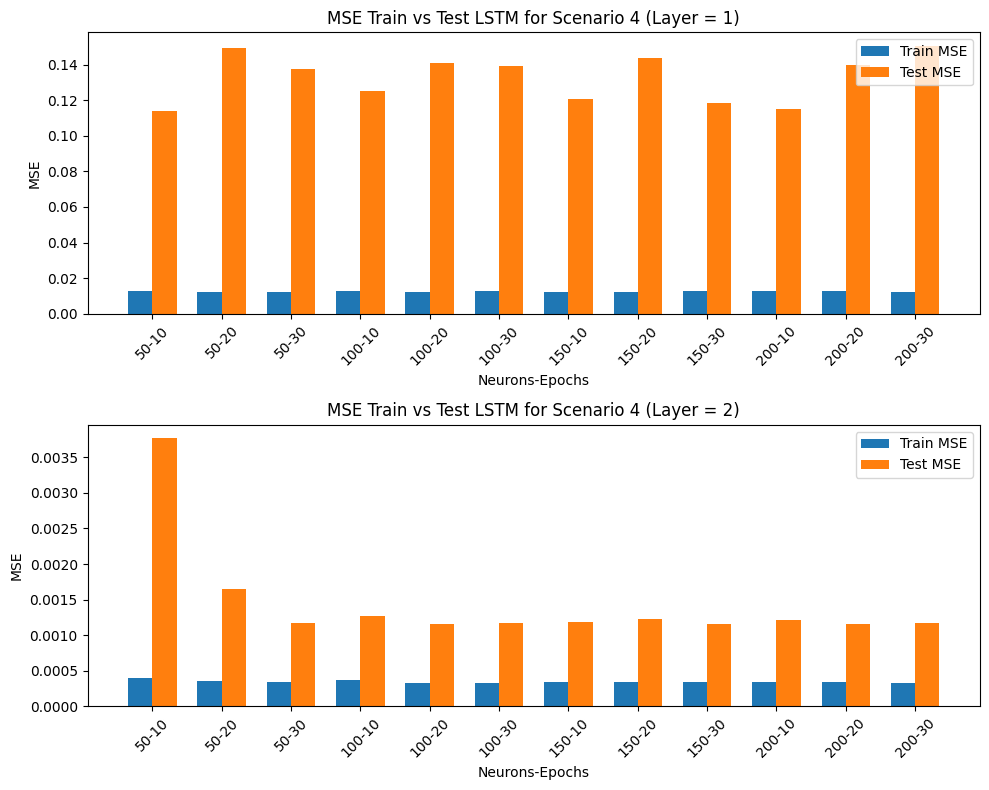

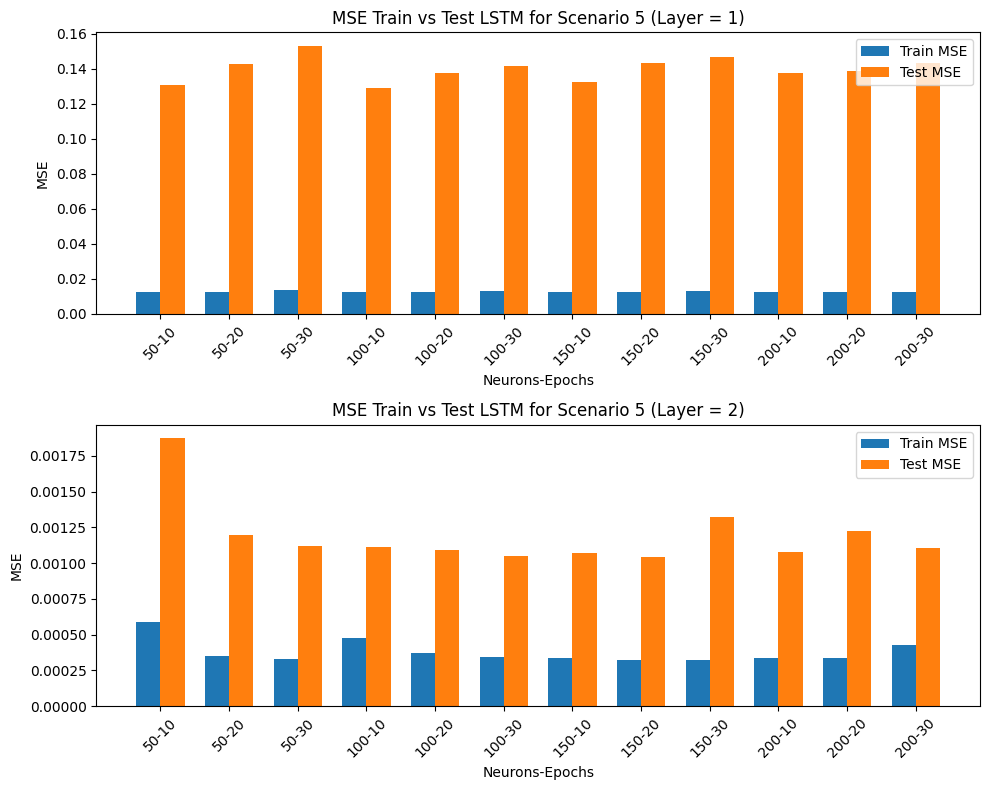

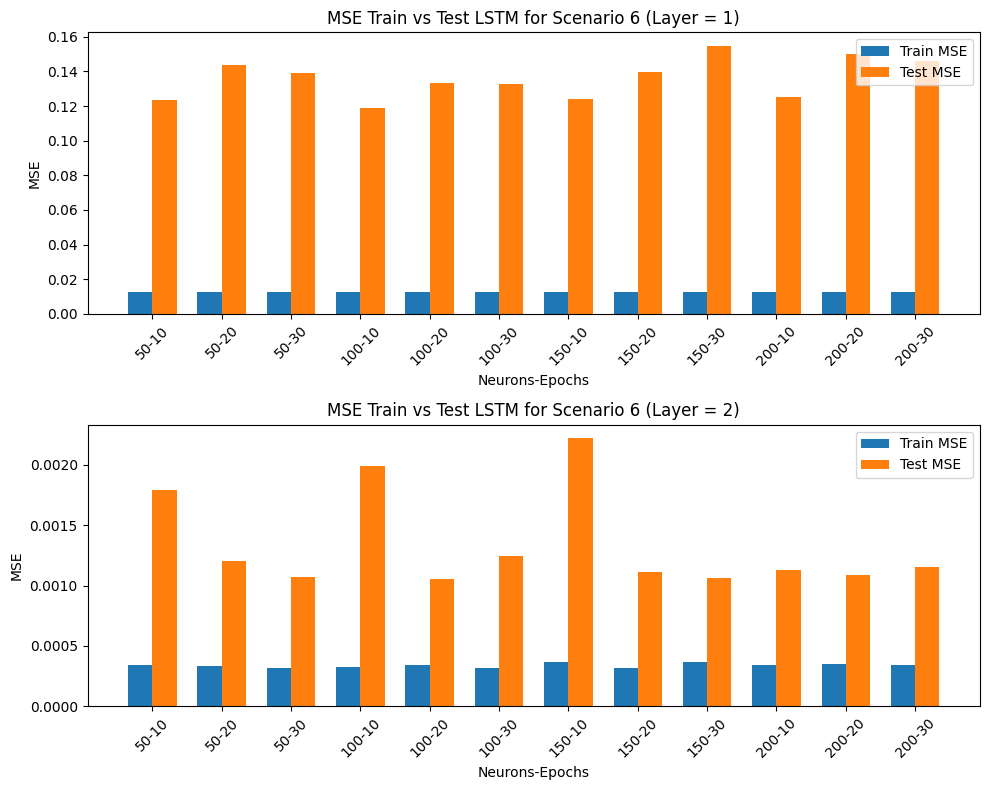

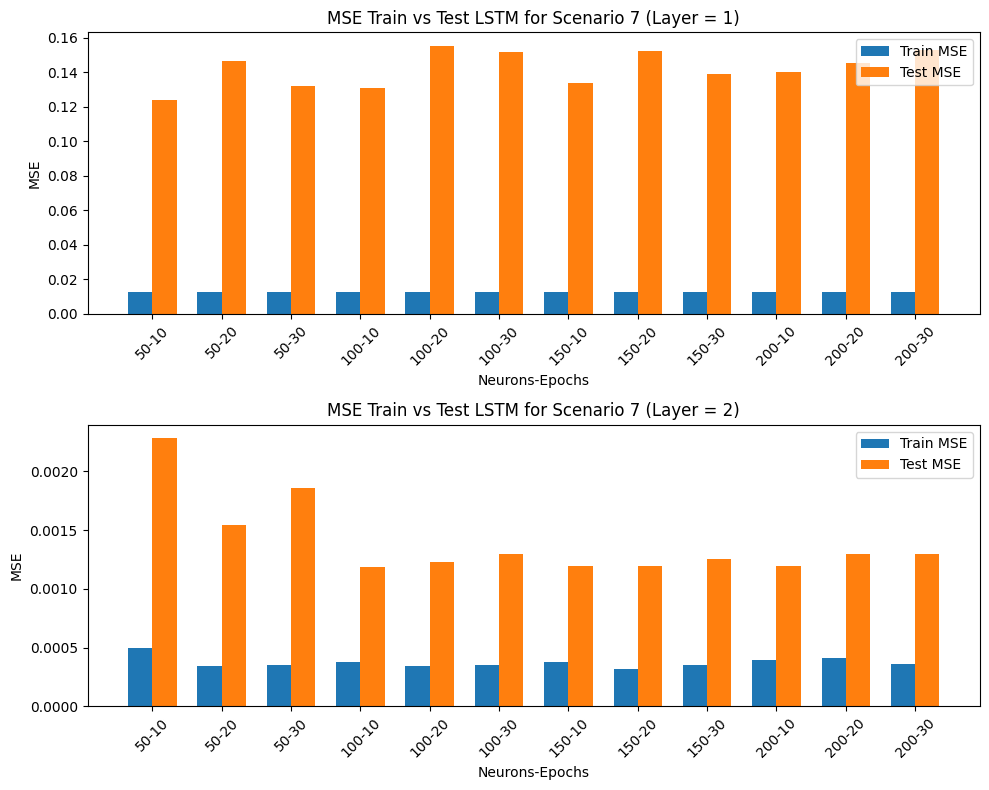

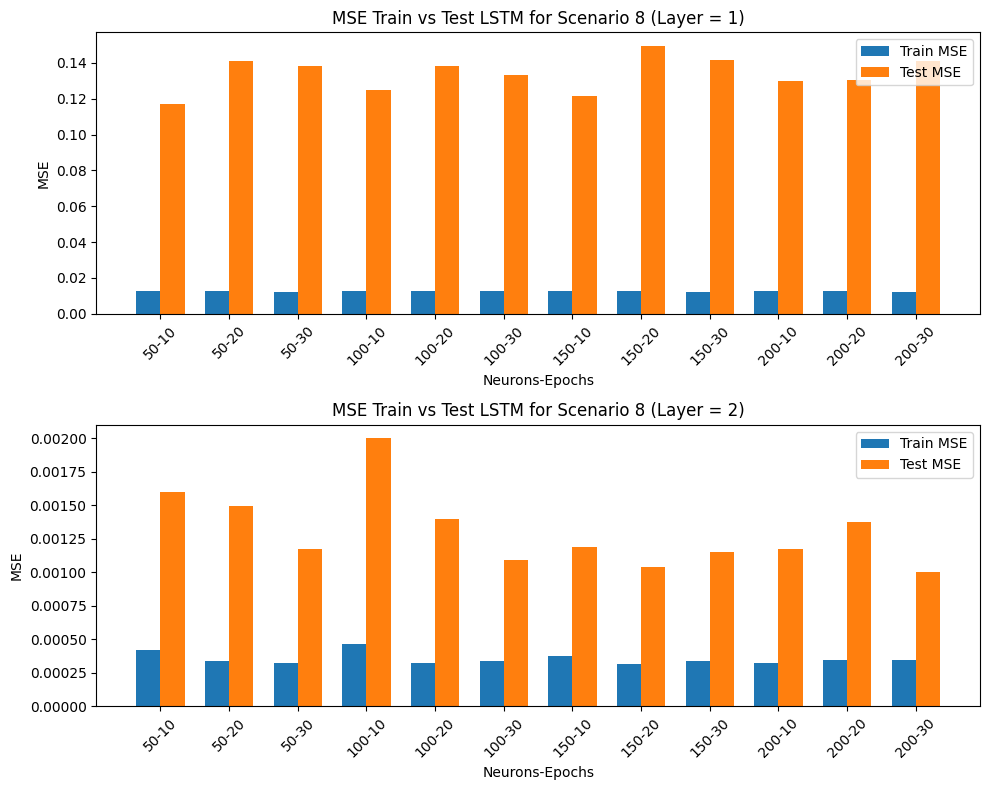

In [18]:
import matplotlib.pyplot as plt
import numpy as np

for scen in range(1, 9):
    scen_indices = hyperparam[hyperparam['scen'] == scen].index
    scen_data = hyperparam.loc[scen_indices]

    layer_1_data = scen_data[scen_data['n_lstm'] == 1]
    layer_2_data = scen_data[scen_data['n_lstm'] == 2]

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

    # Layer 1
    x1 = np.arange(len(layer_1_data))
    width = 0.35
    axes[0].bar(x1 - width/2, layer_1_data['mse_train'], width, label='Train MSE')
    axes[0].bar(x1 + width/2, layer_1_data['mse_test'], width, label='Test MSE')
    axes[0].set_title(f'MSE Train vs Test LSTM for Scenario {scen} (Layer = 1)')
    axes[0].set_ylabel('MSE')
    axes[0].set_xticks(x1)
    axes[0].set_xticklabels([f'{n}-{e}' for n, e in zip(layer_1_data['neurons'], layer_1_data['epochs'])], rotation=45)
    axes[0].set_xlabel('Neurons-Epochs')
    axes[0].legend(loc='upper right')

    # Layer 2
    x2 = np.arange(len(layer_2_data))
    axes[1].bar(x2 - width/2, layer_2_data['mse_train'], width, label='Train MSE')
    axes[1].bar(x2 + width/2, layer_2_data['mse_test'], width, label='Test MSE')
    axes[1].set_title(f'MSE Train vs Test LSTM for Scenario {scen} (Layer = 2)')
    axes[1].set_ylabel('MSE')
    axes[1].set_xticks(x2)
    axes[1].set_xticklabels([f'{n}-{e}' for n, e in zip(layer_2_data['neurons'], layer_2_data['epochs'])], rotation=45)
    axes[1].set_xlabel('Neurons-Epochs')
    axes[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [19]:
best_configs = hyperparam.loc[hyperparam.groupby("scen")[["mse_test"]].idxmin()["mse_test"]]
best_configs

,scen,n_lstm,neurons,epochs,mse_train,mse_test
18,1,2,150,10,0.000350,0.001124
43,2,2,150,20,0.000406,0.001004
69,3,2,200,10,0.000352,0.001133
88,4,2,100,20,0.000325,0.001154
115,5,2,150,20,0.000322,0.001043
136,6,2,100,20,0.000344,0.001052
159,7,2,100,10,0.000374,0.001183
191,8,2,200,30,0.000349,0.001001


In [20]:
best_models = {}

for _, row in best_configs.iterrows():
    scen = int(row["scen"])
    n_lstm = int(row["n_lstm"])
    neurons = int(row["neurons"])
    epochs = int(row["epochs"])

    X_train = globals()[f"X_train_scen{scen}"]
    X_test = globals()[f"X_test_scen{scen}"]
    y_train = globals()[f"y_train_scen{scen}"]
    y_test = globals()[f"y_test_scen{scen}"]

    model = Sequential()
    for i in range(n_lstm):
        if i == 0:
            model.add(LSTM(neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif i < n_lstm - 1:
            model.add(LSTM(neurons, return_sequences=True))
        else:
            model.add(LSTM(neurons))

    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=2, validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    best_models[scen] = {
        "model": model,
        "mse": mse,
        "history": history,
        "scaler": scaler
    }

    globals()[f"model_scen{scen}"] = model

Train on 292 samples, validate on 73 samples
Epoch 1/10
292/292 - 132s - loss: 0.0366 - val_loss: 0.1187
Epoch 2/10
292/292 - 2s - loss: 0.0085 - val_loss: 0.0265
Epoch 3/10
292/292 - 2s - loss: 0.0066 - val_loss: 0.0755
Epoch 4/10
292/292 - 2s - loss: 0.0050 - val_loss: 0.0348
Epoch 5/10
292/292 - 2s - loss: 0.0030 - val_loss: 0.0140
Epoch 6/10
292/292 - 2s - loss: 0.0013 - val_loss: 0.0058
Epoch 7/10
292/292 - 2s - loss: 4.3083e-04 - val_loss: 0.0014
Epoch 8/10
292/292 - 3s - loss: 3.6619e-04 - val_loss: 0.0016
Epoch 9/10
292/292 - 3s - loss: 3.8181e-04 - val_loss: 0.0018
Epoch 10/10
292/292 - 2s - loss: 3.6891e-04 - val_loss: 0.0015
Train on 292 samples, validate on 73 samples
Epoch 1/20
292/292 - 115s - loss: 0.0338 - val_loss: 0.1159
Epoch 2/20
292/292 - 2s - loss: 0.0114 - val_loss: 0.0718
Epoch 3/20
292/292 - 2s - loss: 0.0076 - val_loss: 0.1008
Epoch 4/20
292/292 - 2s - loss: 0.0059 - val_loss: 0.0406
Epoch 5/20
292/292 - 2s - loss: 0.0041 - val_loss: 0.0319
Epoch 6/20
292/292 

In [21]:
for scen, result in best_models.items():
    print(f"Scenario: {scen}")
    print(f"MSE (test): {result['mse']}")

Scenario: 1
MSE (test): 0.0014878176157344593
Scenario: 2
MSE (test): 0.0009982835995547745
Scenario: 3
MSE (test): 0.0011649034139253466
Scenario: 4
MSE (test): 0.0012535131764113007
Scenario: 5
MSE (test): 0.001015297127872615
Scenario: 6
MSE (test): 0.0013940303324005167
Scenario: 7
MSE (test): 0.0014920800967407539
Scenario: 8
MSE (test): 0.0010612291247267286


In [22]:
for scen in range(1, 9):
    globals()[f"model_scen{scen}"].summary()

Model: "sequential_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_288 (LSTM)              (None, 1, 150)            92400     
_________________________________________________________________
lstm_289 (LSTM)              (None, 150)               180600    
_________________________________________________________________
dense_384 (Dense)            (None, 25)                3775      
_________________________________________________________________
dense_385 (Dense)            (None, 1)                 26        
Total params: 276,801
Trainable params: 276,801
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_290 (LSTM)              (None, 1, 150)            93000     
______________________

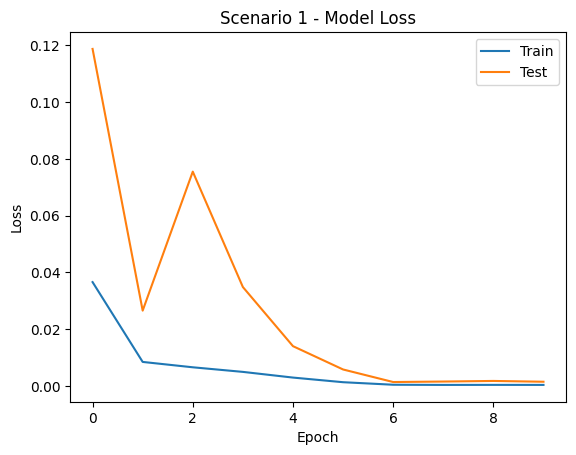

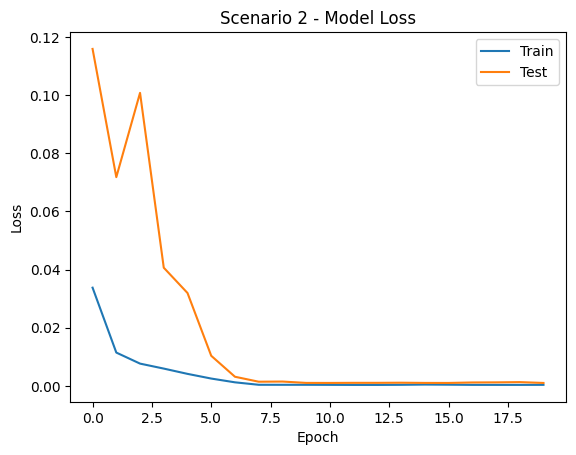

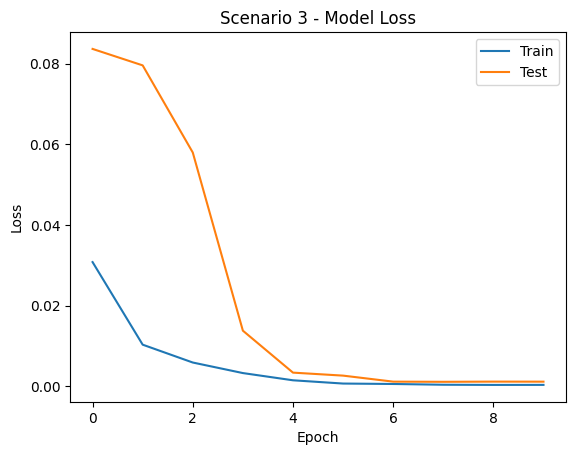

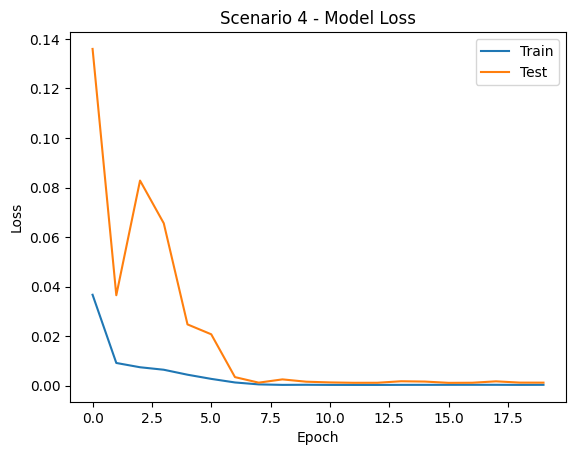

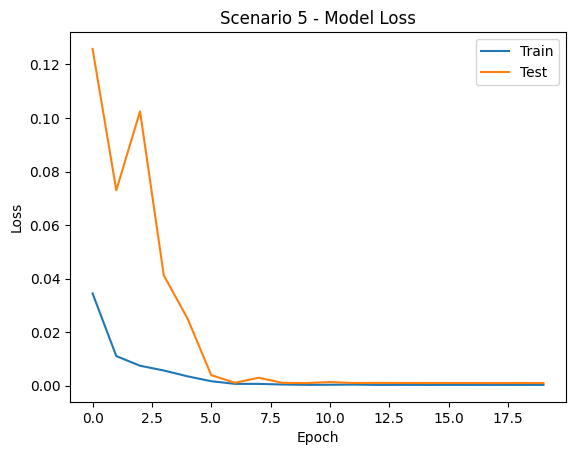

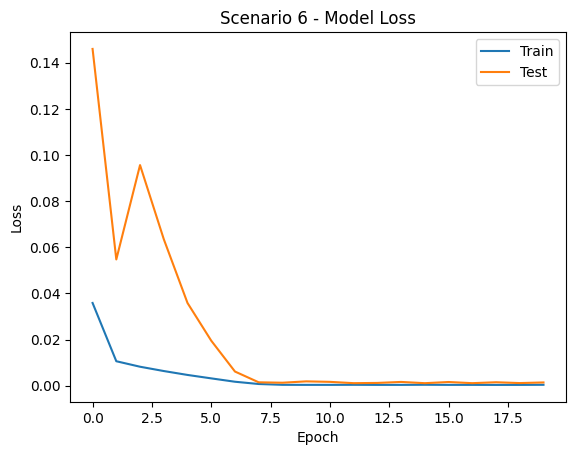

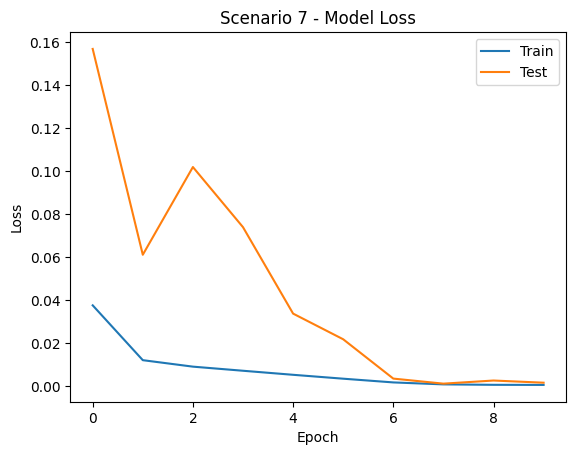

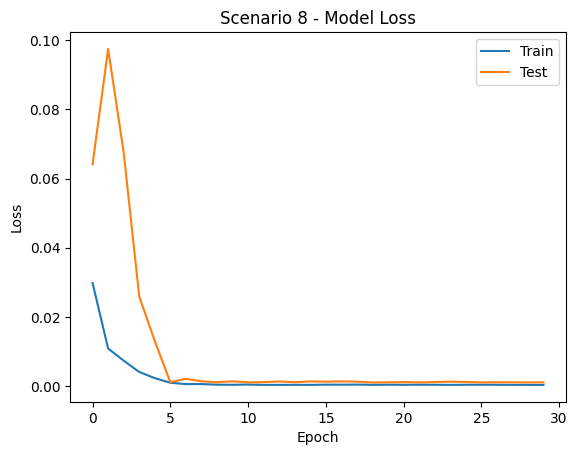

In [23]:
for scen in range(1, 9):
    history = best_models[scen]["history"]
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Scenario {scen} - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

In [24]:
for scen in best_models:
    model = best_models[scen]["model"]
    X_train = globals()[f"X_train_scen{scen}"]
    y_train = globals()[f"y_train_scen{scen}"]
    scaler = best_models[scen]["scaler"]
    
    y_pred = model.predict(X_train)
    inverse_predictions = inverse_transform(scaler, y_pred)
    inverse_y_train = inverse_transform(scaler, y_train)
    
    compare = pd.DataFrame({'Predicted': inverse_predictions, 'Actual': inverse_y_train})
    print(f"Comparison for scen{scen}:\n", compare.head())
    print("="*50)

Comparison for scen1:
       Predicted        Actual
0  23725.990347  23475.466797
1  23877.241715  22362.679688
2  23381.372397  22353.349609
3  22712.237198  22435.513672
4  22814.715840  22429.757813
Comparison for scen2:
       Predicted        Actual
0  23684.021113  23475.466797
1  23809.692350  22362.679688
2  23329.666368  22353.349609
3  22705.932180  22435.513672
4  22803.719776  22429.757813
Comparison for scen3:
       Predicted        Actual
0  23715.580724  23475.466797
1  23886.037684  22362.679688
2  23459.918457  22353.349609
3  22711.108301  22435.513672
4  22797.201465  22429.757813
Comparison for scen4:
       Predicted        Actual
0  23818.833876  23475.466797
1  23924.219336  22362.679688
2  23529.478114  22353.349609
3  22687.272829  22435.513672
4  22806.070422  22429.757813
Comparison for scen5:
       Predicted        Actual
0  23763.666590  23475.466797
1  23778.525275  22362.679688
2  23310.415059  22353.349609
3  22681.523038  22435.513672
4  22782.625753

In [25]:
for scen in best_models:
    model = best_models[scen]["model"]
    X_test = globals()[f"X_test_scen{scen}"]
    y_test = globals()[f"y_test_scen{scen}"]
    scaler = best_models[scen]["scaler"]
    
    y_pred = model.predict(X_test)
    inverse_predictions = inverse_transform(scaler, y_pred)
    inverse_y_test = inverse_transform(scaler, y_test)
    
    compare = pd.DataFrame({'Predicted': inverse_predictions, 'Actual': inverse_y_test})
    print(f"Comparison for scen{scen}:\n", compare.head())
    print("="*50)

Comparison for scen1:
       Predicted        Actual
0  42379.671820  42270.527344
1  43553.906145  43652.250000
2  43928.117872  43869.152344
3  44817.983066  43997.902344
4  44983.581088  43739.542969
Comparison for scen2:
       Predicted        Actual
0  41358.315445  42270.527344
1  43073.330613  43652.250000
2  43448.715219  43869.152344
3  43675.522434  43997.902344
4  44477.555324  43739.542969
Comparison for scen3:
       Predicted        Actual
0  41793.597638  42270.527344
1  42934.991327  43652.250000
2  43275.613289  43869.152344
3  44145.100642  43997.902344
4  44316.431902  43739.542969
Comparison for scen4:
       Predicted        Actual
0  41925.964064  42270.527344
1  43045.438773  43652.250000
2  43491.733425  43869.152344
3  44269.201418  43997.902344
4  44395.405811  43739.542969
Comparison for scen5:
       Predicted        Actual
0  41191.540760  42270.527344
1  42970.349240  43652.250000
2  43380.917720  43869.152344
3  43475.449312  43997.902344
4  44365.680243

# METRIKS EVALUASI

In [26]:
for i in range(1, 9):
    model = best_models[i]["model"]
    X_train_scenario = globals()[f"X_train_scen{i}"]
    y_train_scenario = globals()[f"y_train_scen{i}"]
    X_test_scenario = globals()[f"X_test_scen{i}"]
    y_test_scenario = globals()[f"y_test_scen{i}"]
    scaler = best_models[i]["scaler"]

    y_pred_train = model.predict(X_train_scenario)
    y_pred_test = model.predict(X_test_scenario)

    inverse_predictions_train = inverse_transform(scaler, y_pred_train, model_type='lstm')
    y_train_original = inverse_transform(scaler, y_train_scenario, model_type='lstm')
    inverse_predictions_test = inverse_transform(scaler, y_pred_test, model_type='lstm')
    y_test_original = inverse_transform(scaler, y_test_scenario, model_type='lstm')

    mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
    mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
    rmse_model_train = np.sqrt(mse_model_train)
    rmse_model_test = np.sqrt(mse_model_test)

    r2_lstm_train = r2_score(y_train_original, inverse_predictions_train)
    r2_lstm_test = r2_score(y_test_original, inverse_predictions_test)

    print(f"Results for scen{i}:")
    print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
    print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
    print("======================================================")
    print("R-squared Train Set:", r2_lstm_train)
    print("R-squared Test Set:", r2_lstm_test)
    print("======================================================")

Results for scen1:
Root Mean Squared Error (RMSE) Train Set: 807.4809740762868
Root Mean Squared Error (RMSE) Test Set: 1632.2824534766821
R-squared Train Set: 0.9703892831067501
R-squared Test Set: 0.8869034961335056
Results for scen2:
Root Mean Squared Error (RMSE) Train Set: 750.3346534262126
Root Mean Squared Error (RMSE) Test Set: 1337.049334127441
R-squared Train Set: 0.9744321426697063
R-squared Test Set: 0.924115440103073
Results for scen3:
Root Mean Squared Error (RMSE) Train Set: 780.651806997103
Root Mean Squared Error (RMSE) Test Set: 1444.3266440430637
R-squared Train Set: 0.9723242713286094
R-squared Test Set: 0.9114498295598791
Results for scen4:
Root Mean Squared Error (RMSE) Train Set: 765.1403067622214
Root Mean Squared Error (RMSE) Test Set: 1498.2521708288748
R-squared Train Set: 0.9734131743845266
R-squared Test Set: 0.9047141556173074
Results for scen5:
Root Mean Squared Error (RMSE) Train Set: 744.6723499938533
Root Mean Squared Error (RMSE) Test Set: 1348.394718

# VISUALISASI

## Line Plot Train

Line plot for Train Set: Scenario 1


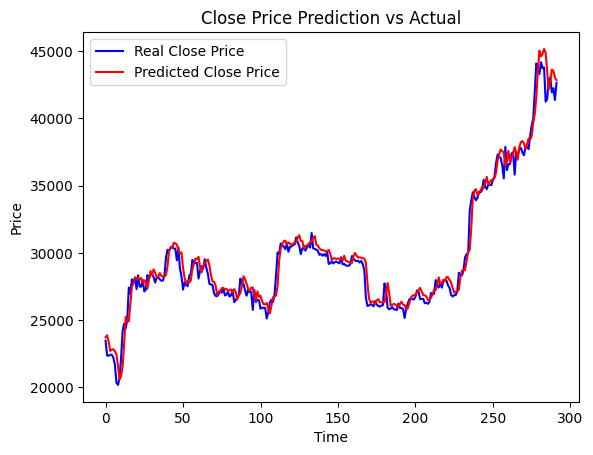

Line plot for Train Set: Scenario 2


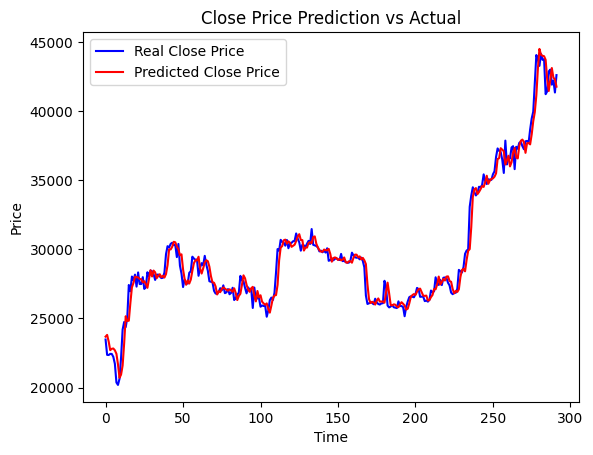

Line plot for Train Set: Scenario 3


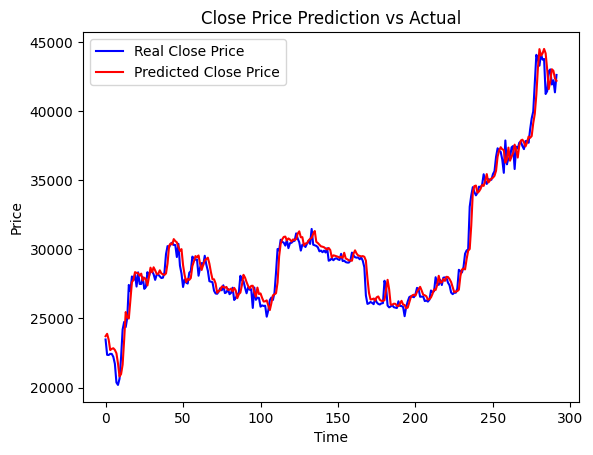

Line plot for Train Set: Scenario 4


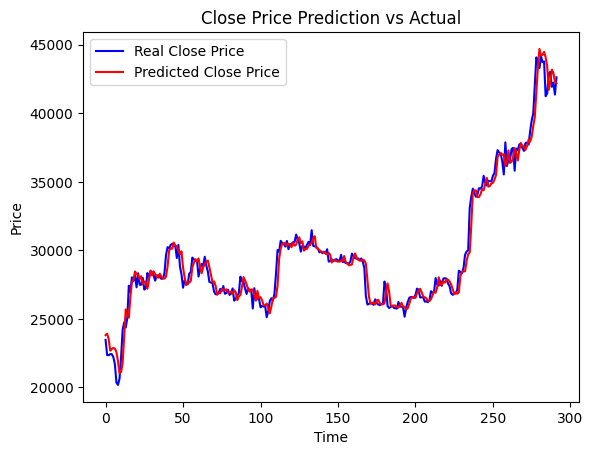

Line plot for Train Set: Scenario 5


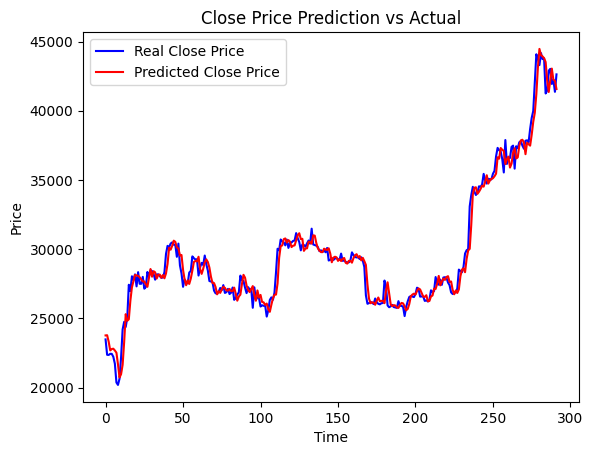

Line plot for Train Set: Scenario 6


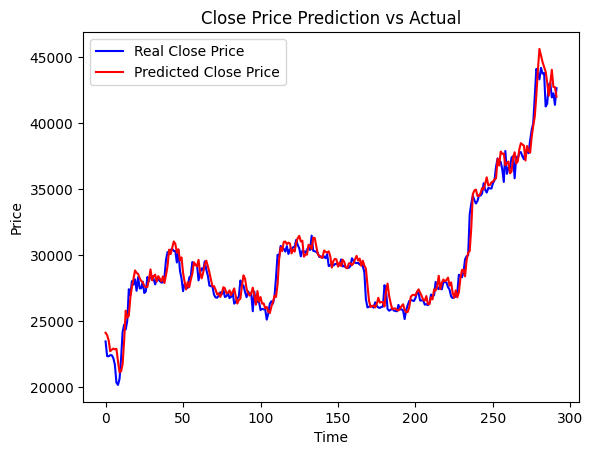

Line plot for Train Set: Scenario 7


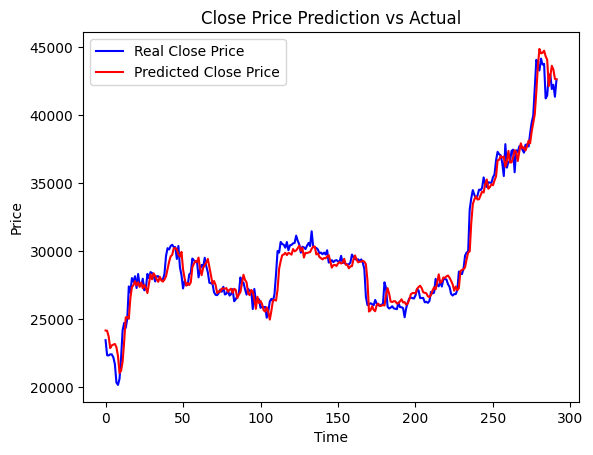

Line plot for Train Set: Scenario 8


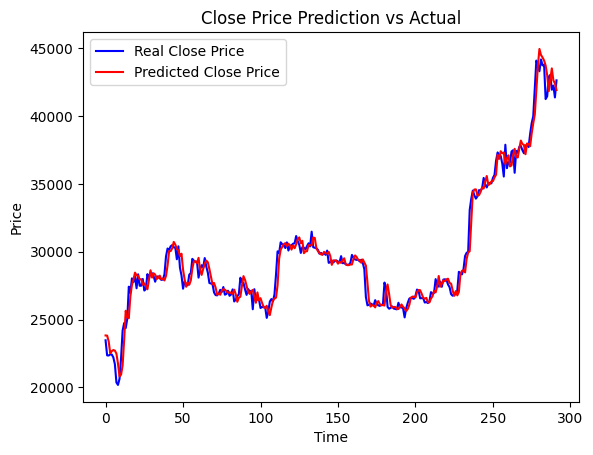

In [27]:
for i in range(1, 9):
    model = best_models[i]["model"]
    X_train_scenario = globals()[f"X_train_scen{i}"]
    y_train_scenario = globals()[f"y_train_scen{i}"]
    scaler = best_models[i]["scaler"]
    
    y_pred_train = model.predict(X_train_scenario)
    
    inverse_predictions_train = inverse_transform(scaler, y_pred_train, model_type='lstm')
    y_train_original = inverse_transform(scaler, y_train_scenario, model_type='lstm')

    print(f"Line plot for Train Set: Scenario {i}")
    lineplot(y_train_original, inverse_predictions_train)

## Scatter Plot Train

Scatter plot for Train Set: Scenario 1


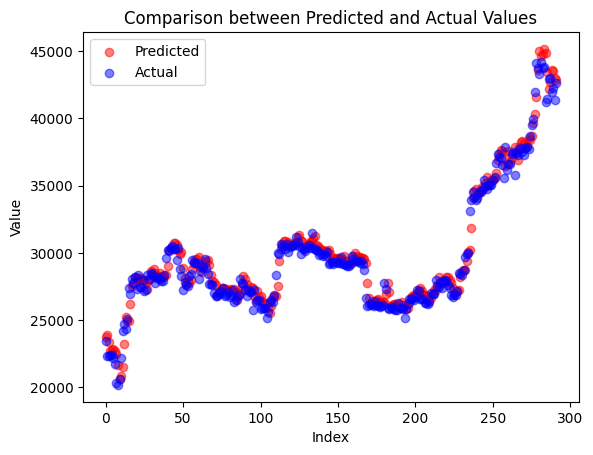

Scatter plot for Train Set: Scenario 2


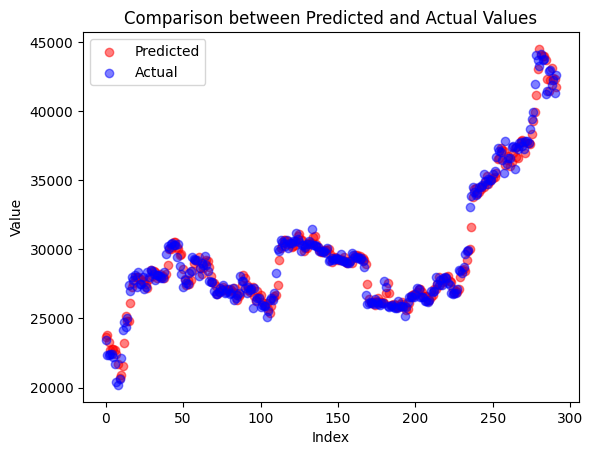

Scatter plot for Train Set: Scenario 3


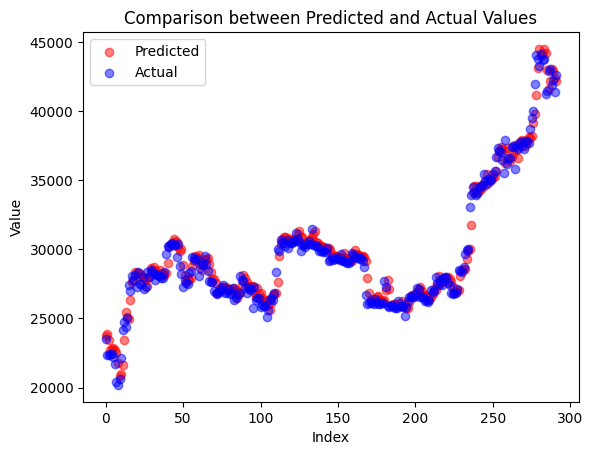

Scatter plot for Train Set: Scenario 4


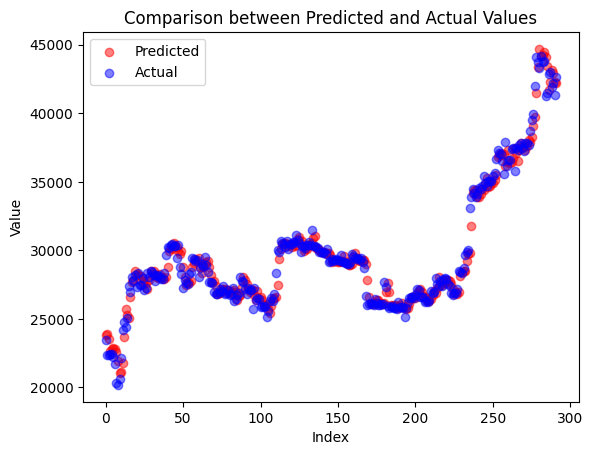

Scatter plot for Train Set: Scenario 5


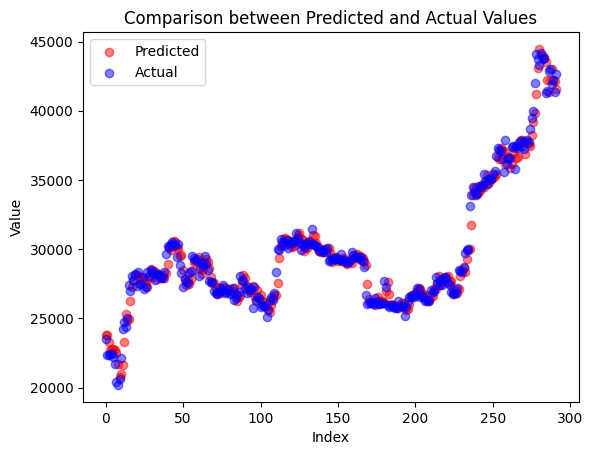

Scatter plot for Train Set: Scenario 6


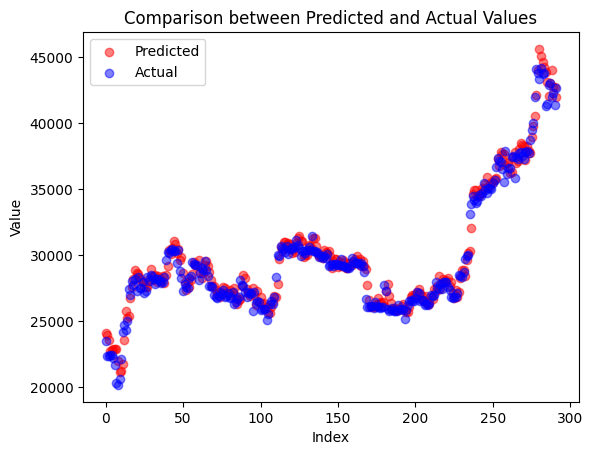

Scatter plot for Train Set: Scenario 7


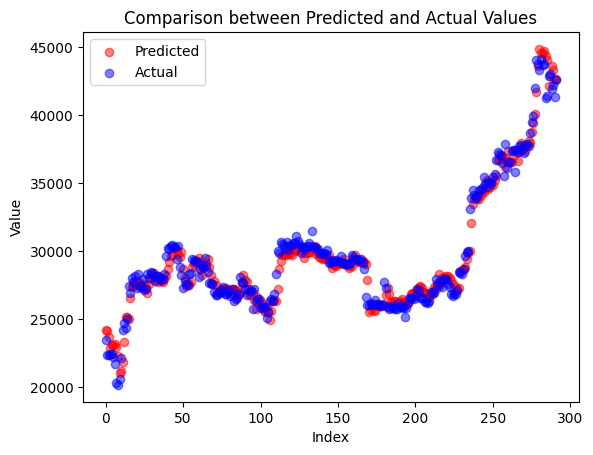

Scatter plot for Train Set: Scenario 8


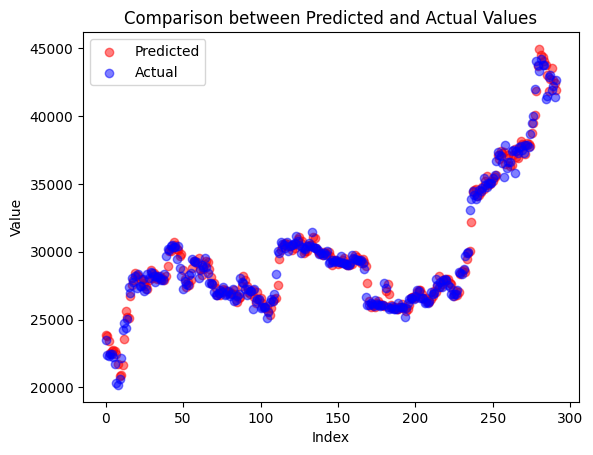

In [28]:
for i in range(1, 9):
    model = best_models[i]["model"]
    X_train_scenario = globals()[f"X_train_scen{i}"]
    y_train_scenario = globals()[f"y_train_scen{i}"]
    scaler = best_models[i]["scaler"]
    
    y_pred_train = model.predict(X_train_scenario)
    
    inverse_predictions_train = inverse_transform(scaler, y_pred_train, model_type='lstm')
    y_train_original = inverse_transform(scaler, y_train_scenario, model_type='lstm')

    print(f"Scatter plot for Train Set: Scenario {i}")
    scatterplot(y_train_original, inverse_predictions_train)

## Line Plot Test

Line plot for Test Set: Scenario 1


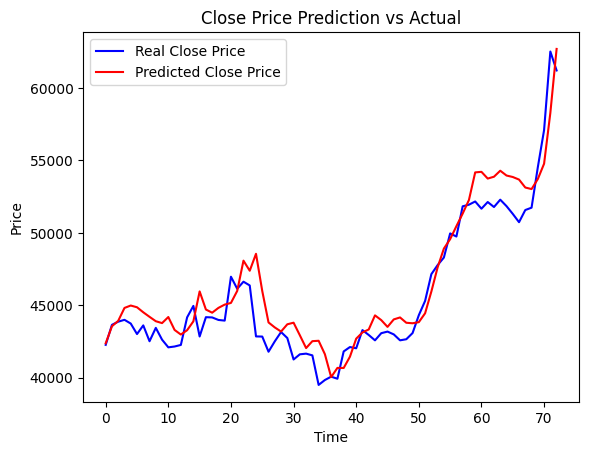

Line plot for Test Set: Scenario 2


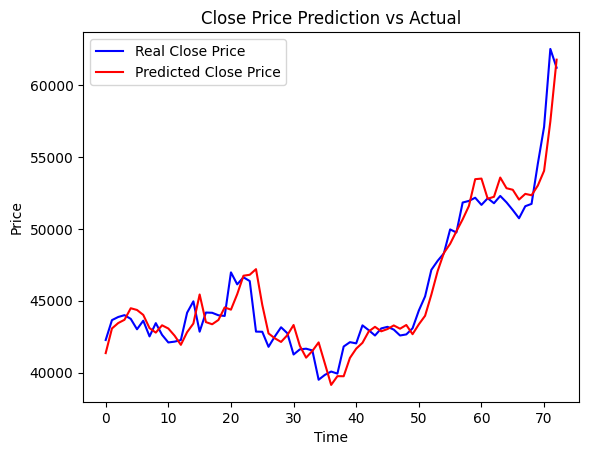

Line plot for Test Set: Scenario 3


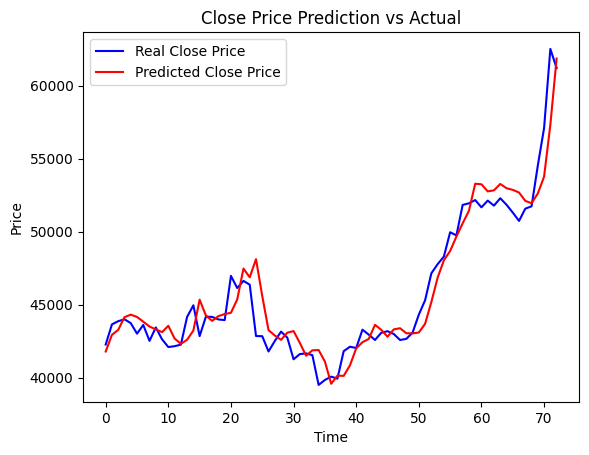

Line plot for Test Set: Scenario 4


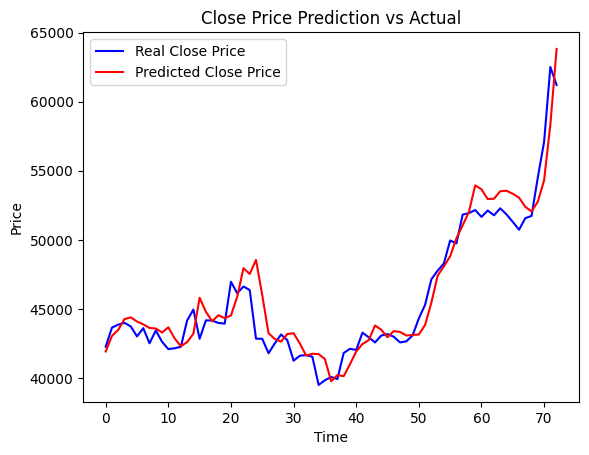

Line plot for Test Set: Scenario 5


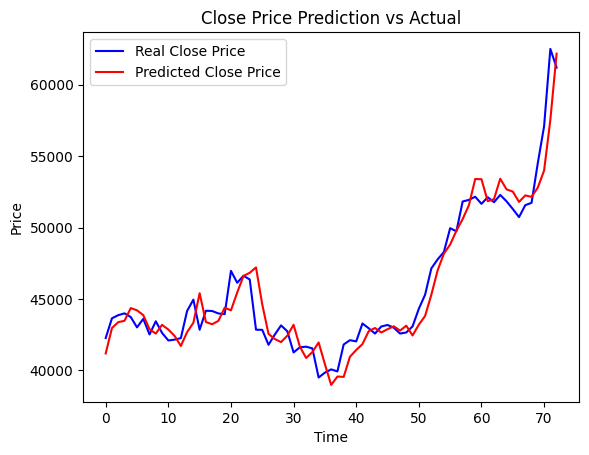

Line plot for Test Set: Scenario 6


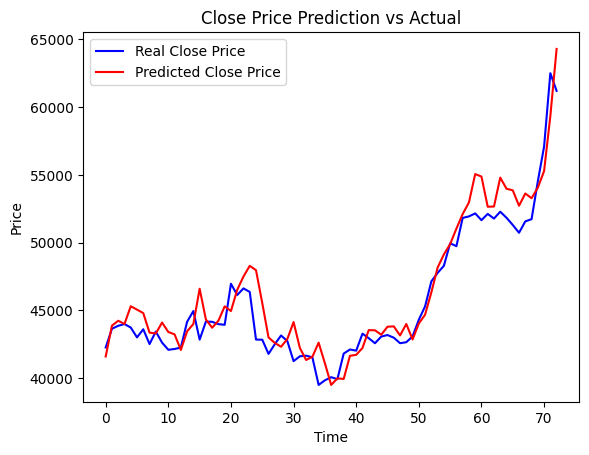

Line plot for Test Set: Scenario 7


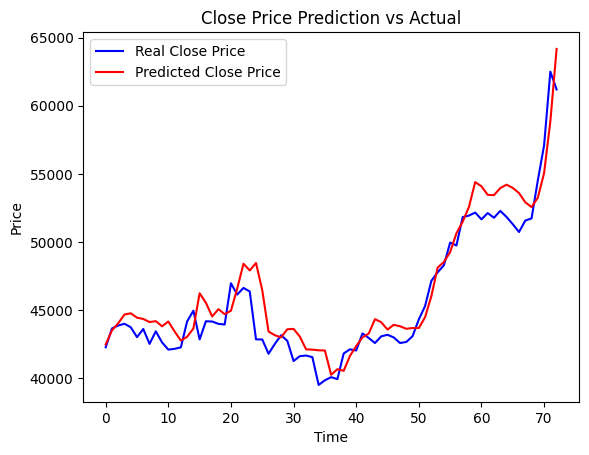

Line plot for Test Set: Scenario 8


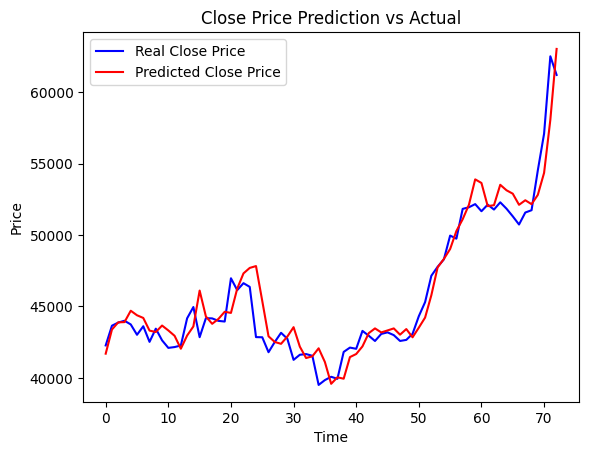

In [29]:
for i in range(1, 9):
    model = best_models[i]["model"]
    X_test_scenario = globals()[f"X_test_scen{i}"]
    y_test_scenario = globals()[f"y_test_scen{i}"]
    scaler = best_models[i]["scaler"]
    
    y_pred_test = model.predict(X_test_scenario)
    
    inverse_predictions_test = inverse_transform(scaler, y_pred_test, model_type='lstm')
    y_test_original = inverse_transform(scaler, y_test_scenario, model_type='lstm')

    print(f"Line plot for Test Set: Scenario {i}")
    lineplot(y_test_original, inverse_predictions_test)

## Scatter Plot Test

Scatter plot for Test Set: Scenario 1


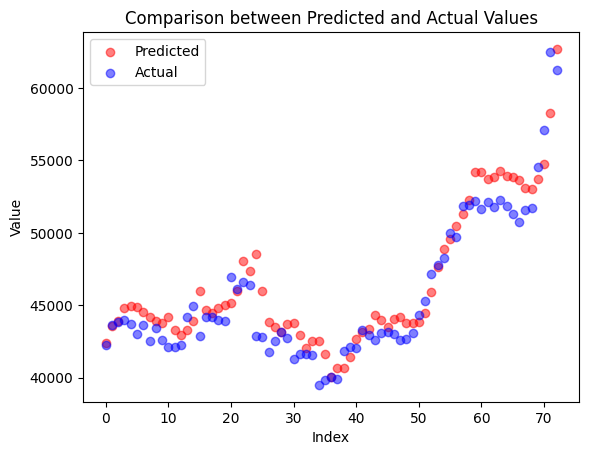

Scatter plot for Test Set: Scenario 2


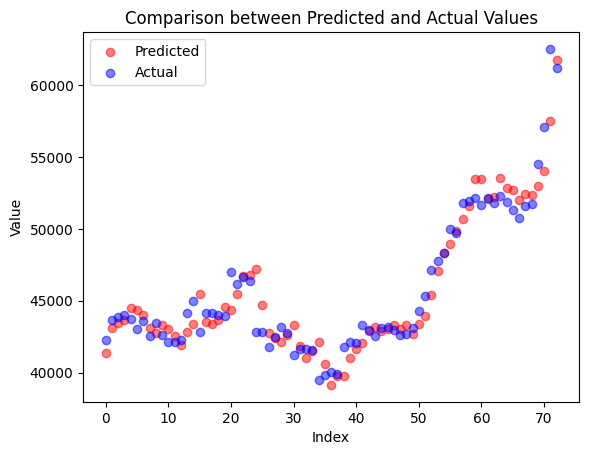

Scatter plot for Test Set: Scenario 3


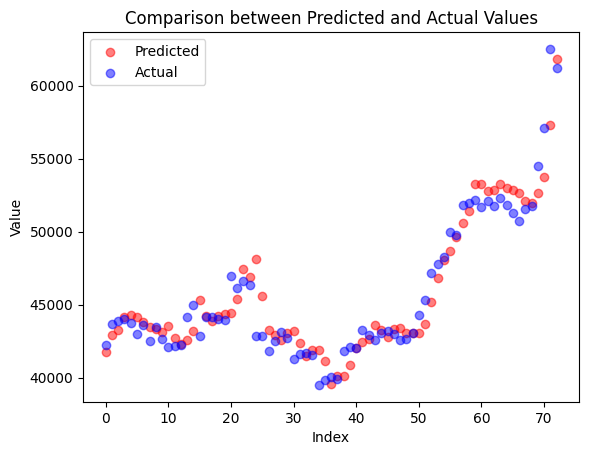

Scatter plot for Test Set: Scenario 4


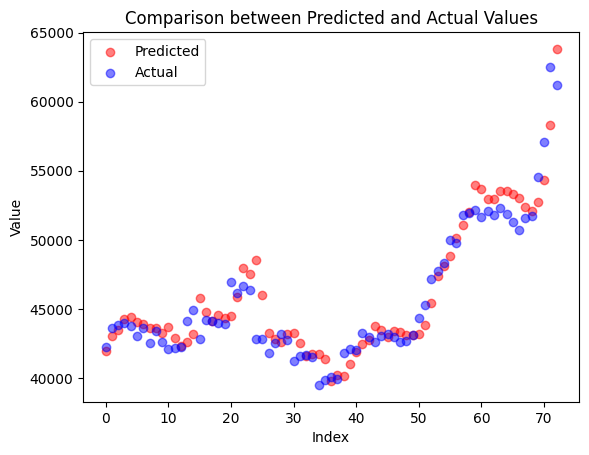

Scatter plot for Test Set: Scenario 5


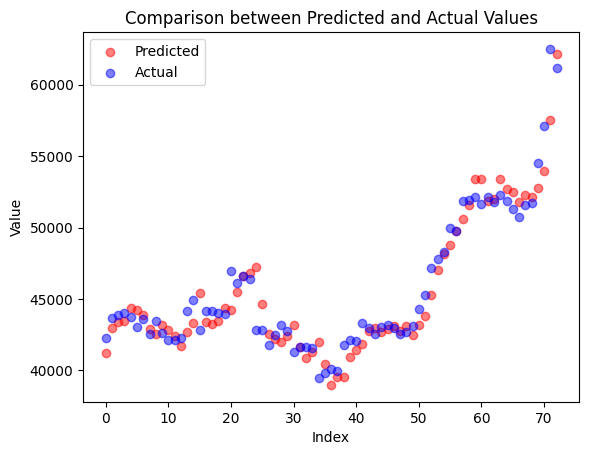

Scatter plot for Test Set: Scenario 6


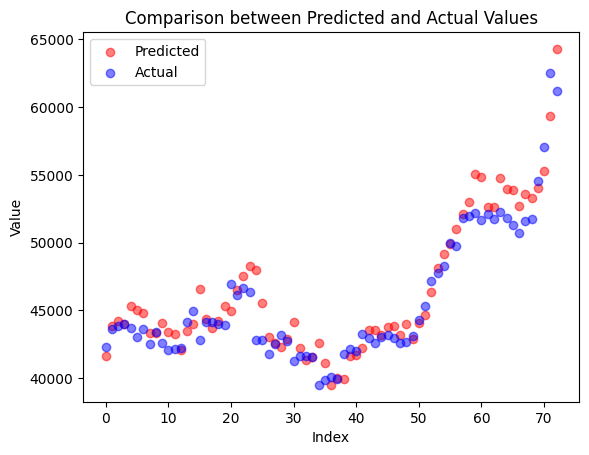

Scatter plot for Test Set: Scenario 7


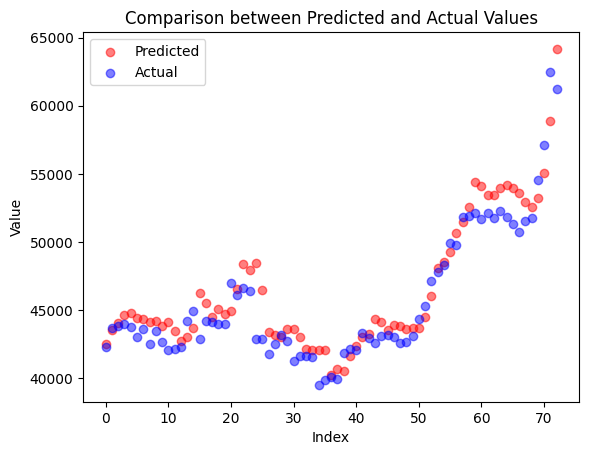

Scatter plot for Test Set: Scenario 8


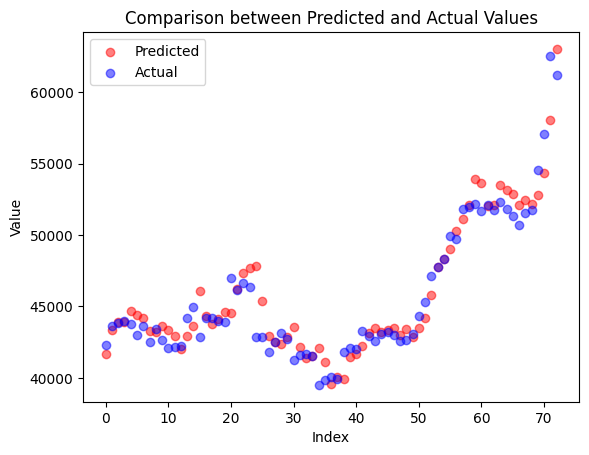

In [30]:
for i in range(1, 9):
    model = best_models[i]["model"]
    X_test_scenario = globals()[f"X_test_scen{i}"]
    y_test_scenario = globals()[f"y_test_scen{i}"]
    scaler = best_models[i]["scaler"]
    
    y_pred_test = model.predict(X_test_scenario)
    
    inverse_predictions_test = inverse_transform(scaler, y_pred_test, model_type='lstm')
    y_test_original = inverse_transform(scaler, y_test_scenario, model_type='lstm')

    print(f"Scatter plot for Test Set: Scenario {i}")
    scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [51]:
features = ["Open", "High", "Low", "Sentimen"]

explainer = shap.DeepExplainer(model_scen2, X_train_scen2)
shap_values = explainer.shap_values(X_test_scen2)

shap.initjs()

# Manually specify the feature values for the first instance
single_instance = X_test_scen2[0]

shap.force_plot(explainer.expected_value[0], shap_values[0][0], single_instance, feature_names=features)

# TEST DENGAN DATA BARU

In [52]:
dt = pd.read_excel('Data/all_data_validation.xlsx')
dt.head()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
0,2024-03-01,61168.062500,63155.101563,60802.527344,62440.632813,40186368423,positif,59,62440.632813
1,2024-03-02,62431.652344,62458.699219,61657.289063,62029.847656,23888473685,positif,46,62029.847656
2,2024-03-03,62031.578125,63230.210938,61435.023438,63167.371094,26253811450,positif,44,63167.371094
3,2024-03-04,63137.003906,68537.031250,62386.519531,68330.414063,70670471105,positif,81,68330.414063
4,2024-03-05,68341.054688,69170.625000,59323.910156,63801.199219,102802940877,positif,100,63801.199219


In [53]:
dt = dt.drop(columns=["Date", 'Adj_Close', 'Volume', 'Index'])

In [54]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
dt['Sentimen'] = dt['Sentimen'].map(sentimen_mapping)

In [55]:
dt.describe()

,Open,High,Low,Sentimen,Close
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,67372.752394,69272.725933,65532.276714,0.548387,67702.439264
std,3292.243235,2911.385403,3273.325051,0.809885,3157.882425
min,61168.062500,62458.699219,59323.910156,-1.000000,61912.773438
25%,64693.548828,68068.425782,62617.595703,0.500000,65403.253907
50%,68299.257813,69170.625000,65655.531250,1.000000,68330.414063
75%,69770.613282,71456.761719,68472.476563,1.000000,69925.820312
max,73079.375000,73750.070313,71334.093750,1.000000,73083.500000


In [56]:
X, y, scalers = scale_data(dt)

In [57]:
predictions = model_scen2.predict(X) 

inverse_predictions_new = inverse_transform(scalers, predictions)
y_test_original_new = inverse_transform(scalers, y)

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_new.flatten(), 'Actual': y_test_original_new.flatten()})
compare_model_test

,Predicted,Actual
0,62700.723154,62029.847656
1,63074.747249,63167.371094
2,63148.637255,68330.414063
3,65536.314860,63801.199219
4,66134.492009,66106.804688
5,65561.084963,66925.484375
6,67342.890787,68300.093750
7,68546.911086,68498.882813
8,69098.231312,69019.789063
9,69514.736181,72123.906250


In [58]:
mse_model_newdata = mean_squared_error(y_test_original_new, inverse_predictions_new)
rmse_model_newdata = np.sqrt(mse_model_newdata)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_newdata)
print("======================================================")

# Menghitung R-square
r2_xgb_test = r2_score(y_test_original_new, inverse_predictions_new)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Test Set: 2393.2073191990803
R-squared Test Set: 0.36492811503919265


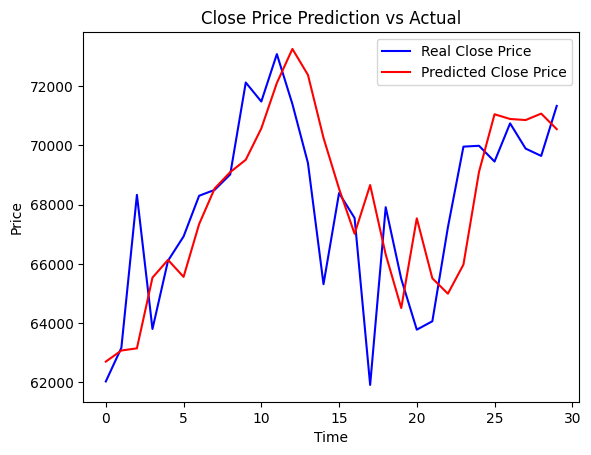

In [59]:
lineplot(y_test_original_new, inverse_predictions_new)

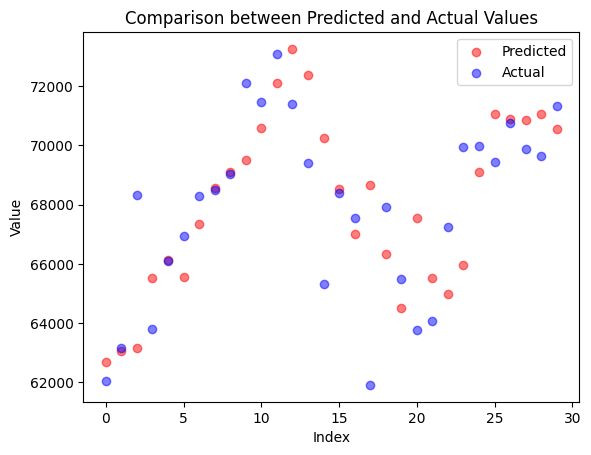

In [60]:
scatterplot(y_test_original_new, inverse_predictions_new)